Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.32      0.42      4643
           1       0.75      0.90      0.82     10554

    accuracy                           0.73     15197
   macro avg       0.67      0.61      0.62     15197
weighted avg       0.70      0.73      0.70     15197

Confusion Matrix:
 [[1507 3136]
 [1025 9529]]

SGDClassifier (Logistic Loss) Coefficients (sorted by value):
                 Feature  Coefficient
2    Payment Method_Card     1.751053
4  Payment Method_PayPal     1.094623
0                    Age    -0.445251
3  Payment Method_MB WAY    -0.457067
1     Transaction Amount    -0.500012


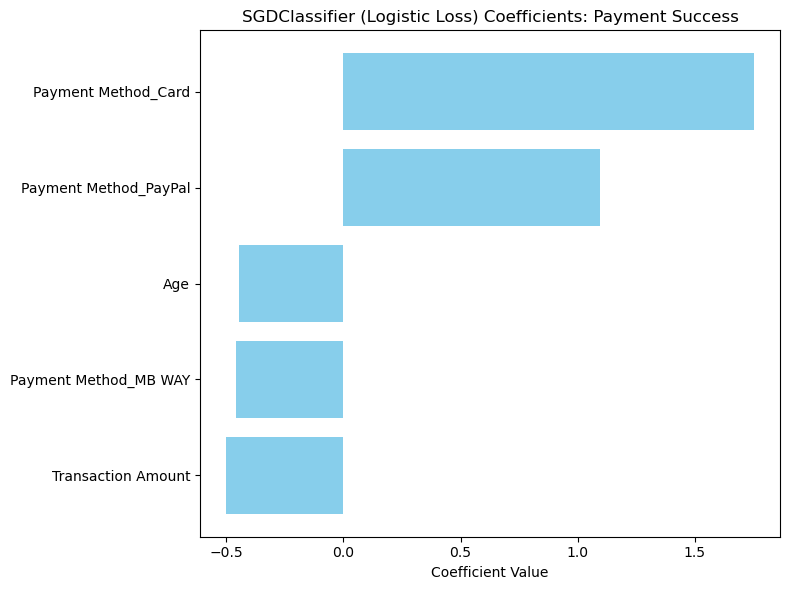

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


# 1. Load Dataset

df = pd.read_csv('eledget_single_dataset_stronger_patterns.csv')


# 2. Filter Out Only Non-Abandoned Orders

df = df[df['Cart Abandoned'] == 'No']


# 3. Keep Relevant Columns for Payment Success

df = df[['Age', 'Payment Method', 'Transaction Amount', 'Transaction Success']]


# 4. Prepare Target & Features

df['Transaction Success'] = df['Transaction Success'].map({'Yes': 1, 'No': 0})

y = df['Transaction Success']
X = df.drop('Transaction Success', axis=1)


# 5. Identify Numeric & Categorical Columns

numeric_features = ['Age', 'Transaction Amount']
categorical_features = ['Payment Method']


# 6. Create Preprocessing + Modeling Pipeline

# Use drop='first' to avoid perfect collinearity, one Payment Method is baseline.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# SGDClassifier with "log_loss" to get positive/negative coefficients.
sgd_model = SGDClassifier(
    loss='log_loss',    # Use 'log_loss' for logistic loss
    penalty='l2',
    random_state=42,
    max_iter=1000,
    tol=1e-3
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sgd', sgd_model)
])


# 7. Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# 8. Fit and evaluate the Model

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# 9. Extract & Display Coefficients

# Numeric feature names
num_feature_names = numeric_features

# One-hot-encoded feature names for Payment Method
ohe_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

all_feature_names = num_feature_names + list(ohe_feature_names)
coefficients = pipeline.named_steps['sgd'].coef_[0]

coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\nSGDClassifier (Logistic Loss) Coefficients (sorted by value):")
print(coef_df)


# 10. Plot the Coefficients

plt.figure(figsize=(8, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel("Coefficient Value")
plt.title("SGDClassifier (Logistic Loss) Coefficients: Payment Success")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
